In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import re
import os
import nltk
import gensim
import string
import time
#import random
from mpl_toolkits import mplot3d
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from shapely.geometry import Point, Polygon, LineString
#random.seed(123)

C:\Users\Krist\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Functions used in this script

In [2]:
# Checking the occurence of topic-related messages

def findTopicRelatedMessages(singleMessage,separationWords,obs,topicRelatedObs,topicRelatedWordsCount):
    global months
    if type(singleMessage)==str:
        temp = cleanWords(singleMessage.lower()).split()
    else:
        temp = singleMessage[:]
    temp = list(set(temp))
    
    if any([True if ele in temp else False for ele in separationWords]):           
        topicRelatedObs.append(obs)
        # Word counting based on the emergency-related-messages
        for word in temp:
            # To disregard the words that we already use to extract the messages 
            if word not in months:
                if word not in topicRelatedWordsCount.keys():
                    topicRelatedWordsCount[word] = 1
                else:
                    topicRelatedWordsCount[word] += 1
                    
    return topicRelatedObs,topicRelatedWordsCount

In [3]:
def findNewWord(sortedWords,separationWords,collectionOfSeparationWords):
    run,hold = 0,0
    while(hold == 0):
        if run < (len(sortedWords)):
            if any([True if sortedWords[run][0] in group else False for group in collectionOfSeparationWords]):
                run += 1
            else:
                separationWords.append(sortedWords[run][0])
                hold = 1
                return separationWords
        else:
            raise ValueError ('The end of the sorted word-count-list has been reached')
            break

In [4]:
############## NOTE: A CERTAIN FORMAT OF THE VARIABLES ARE REQUIRED #############
# names: Should be a list of strings
# groups: Should be a list of lists, where each lists contains a word (string) associated with that topic.
# counter: Should be a dictionary, with a key for each topic and each value initialised to zero.
# dataFrame: Should be pandas dataframe containing a column named 'Message', which holds the text. 

def significantWordsClassifier(names,groups,counter,dataFrame,restrictIterations=False,numberOfIterations = 20,
                               restrictWords=True,maximumLength=10,writeOutText=False):
    start = time.time()
    bagOfWords = [dict() for i in np.arange(len(names))]
    allObs = [[] for i in np.arange(len(names))]
    doubleCountedObs,ClassifiedObs = [],{}

    # Settings
    slack = dataFrame.shape[0]*1
    tempMessages = dataFrame[:]

    # Put a restriction on the number of iterations, to terminate the algorithm
    #restrictIterations = False#True
    #numberOfIterations = 20
    # Put a restrict on the length of the word-separation-vectors, to terminate the algorithm
    #restrictWords = True#False
    #maximumLength = 10
    # The idea is that we start with some "initial beliefs" about the relevant words to classify the messages
    # within the groups defined above. We go through the messages, count how many we classify, and at the end we add new words
    # to the individual relevant-words-lists. 

    iterations,cleanClassifications = 1,0

    while(cleanClassifications<slack):
        runs = 0
        cleanClassificationObs,doubleCountedObs = [],[]

        if iterations == 1 and writeOutText:
            # Printing the "initial belifs"
            for i,e in enumerate(groups):
                print('The initial words in %s are:' % names[i],e,'\n')

        for obs in tempMessages.index:

            # We go over each message
            individualMessage = tempMessages['Message'].loc[obs]
            individualMessage = cleanWords(individualMessage)

            # We check if it belongs to one of the proposed classification groups, based on the associated "beliefs"
            # that should define the groups.
            for i,topic in enumerate(groups):
                allObs[i],bagOfWords[i] = findTopicRelatedMessages(individualMessage,topic,obs,allObs[i],bagOfWords[i])

            # Figuring out if the current message could belong to multiple classification groups.
            noDoubleCouting = [True if obs in separationObs else False for separationObs in allObs]
            whereIndex = [i for i,e in enumerate(noDoubleCouting) if e == True]

            # If the currenct message occurs more than once, we need to decide where it belongs
            if sum(noDoubleCouting) > 1:
                doubleCountedObs.append((obs,whereIndex))
            elif sum(noDoubleCouting) == 1:
                classificationKey = [e for i,e in enumerate(counter.keys()) if i in whereIndex]
                counter[classificationKey[0]] += 1
                cleanClassifications += 1
                cleanClassificationObs.append(obs)
                ClassifiedObs[obs] = classificationKey[0]
        
        if writeOutText:
            print('\nThe number of double counted observations are: ',len(doubleCountedObs))

        # If there are double counted observation, we gonna figure out where they belong.
        if doubleCountedObs != []:

            for observations in doubleCountedObs:
                # We go through each of the messages that appeared to belong to more than one group.
                intersectionMessage = cleanWords(tempMessages.Message[observations[0]])
                intersectionMessage = list(set(intersectionMessage))

                index = []

                # We check what words it is that have to compare the multiple groups on, as it is only the separation-words
                # that we being considered, when we are to determine which group this multi-labeled-message belongs to.
                for word in intersectionMessage:
                    for group in observations[1]:
                        if word in groups[group] and word not in index:
                            index.append(word)

                # Creating the dateFrame to hold the comparison in
                compare = pd.DataFrame(0,index = index,columns = np.arange(len(groups)))

                for e in observations[1]:
                    total = 0

                    for w,wc in bagOfWords[e].items():
                        if w in groups[e]:
                            total += wc

                    for j in compare.index:

                        if j in groups[e]:
                            compare.loc[j,e] = bagOfWords[e][j] / total
                        else:
                            compare.loc[j,e] = 0
                s = 0
                # We compare the sums of the rows for each classification group, and the largest sum wins the multi-labeled message
                for c,i in enumerate(compare.sum()):
                    if i > s:
                        s = i
                        cg = c

                allObs[cg].append(observations[0])

                # FOR CONSIDERATIONS ON WHEN TO UPDATE THE WORD COUNTS: SEE DOCUMENTATION OR THE END OF THIS SCRIPT.
                for word in intersectionMessage:
                    if word not in months:
                        if word not in bagOfWords[cg].keys():
                            bagOfWords[cg][word] = 1
                        else:
                            bagOfWords[cg][word] += 1

                # Updating the classification count
                cleanClassifications += 1
                classificationKey = [e for i,e in enumerate(counter.keys()) if i == cg]
                counter[classificationKey[0]] += 1
                cleanClassificationObs.append(observations[0])
                ClassifiedObs[observations[0]] = classificationKey[0]

        # Locating the next word, for each topic, to add to the separation list
        for i,topic in enumerate(groups):
            # Finding the most frequent word within each topic
            sortedWords = sorted(bagOfWords[i].items(), key = lambda kv: kv[1],reverse = True)
            # Adding the most frequent word from all the topic-related-messages
            topic = findNewWord(sortedWords,topic,groups)
        
        if writeOutText:
            print('\n The %i iteration resulted in a total of %i observations being classified' % (iterations,
                                                                                                   cleanClassifications))
            for i,e in enumerate(groups):
                print('\nThe words in %s are:' % names[i],e)

        tempMessages = tempMessages.drop(cleanClassificationObs)
        # Stop after a certain level of iterations 
        if restrictIterations:
            if iterations == 20:
                end = time.time()
                if writeOutText:
                    print('\nThe algorithm was terminated through a restriction on the maximum number of iteration allowed.')
                    print('The classification was interupted after %i iterations, which took %f seconds' % (iterations,
                                                                                                            (end - start)))
                break
        if restrictWords:
            if all([True if len(vector) == maximumLength else False for vector in groups]):
                end = time.time()
                if writeOutText:
                    print('\nThe algorithm was terminated through a restriction on the maximum number of words used to classify the messages.')
                    print('The maximum number of words, %i, occured after %i iterations, which took %f seconds' % (maximumLength,
                                                                                                                   iterations,
                                                                                                                   (end - start)))
                break
        iterations += 1

    end = time.time()
    
    print('Maximum Number of Words Allowed: %i ~ It took %f to classify the data' % (maximumLength,(end - start)))
    
    return cleanClassifications/dataFrame.shape[0],counter,groups,(iterations-1),(end-start),ClassifiedObs

### Let's begin

In [5]:
stopWords = stopwords.words('english')
with open('english-words-master/words_alpha.txt','r') as vocabulary:
    vocab = vocabulary.readlines()
vocab = {re.sub('\n','',word) : 1 for word in vocab}

In [6]:
# Reading in the message data
with open('WordCount.txt','r') as data:#C:/Users/Krist/University College London/Spatio-Temporal Data Analysis and Data Mining/
    text = data.readlines()
    
messageWordCount = {}
for line in text:
    temp = re.split('[\n \t]',line)
    temp = [i for i in temp if i != '']
    try:
        messageWordCount[temp[0]] = int(temp[1])
    except:
        print(line)

In [7]:
# Reading in the area data
with open('AreaCount.txt','r') as data:
    text = data.readlines()
    
areaWordsCount = {}
for line in text:
    temp = re.split('[\n \t]',line)
    temp = [i for i in temp if i != '']
    try:
        areaWordsCount[temp[0]] = int(temp[1])
    except:
        print('\n\n',temp)
        print('\n\n',line)

In [8]:
areaWordsSubset = {}
areaWordsInMessage = 0
for key in areaWordsCount.keys():
    if key in messageWordCount.keys():
        areaWordsInMessage += 1
        areaWordsSubset[key] = areaWordsCount[key]
#areaWordsSubset
areaWordsInMessage/len(messageWordCount.keys())

0.04354066985645933

In [9]:
# Remove stopwords from the Message-bag-of-words
# Words we wish to remove:
additionalWordsRemove = ['authority','date','cancel','dnc','msg','this','email','phone',
                        "thru","meter","depth","metre","float","top",'fax']
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
##lowerMessageWordCount = {k.lower(): v for k,v in messageWordCount.items() if k.lower() not in stopWords and k.lower() not in additionalWordsRemove and k.lower() not in singleletters and k.lower() not in months}
# We remove all keys that has a length smaller than 3.
#lowerMessageWordCount = {k:v for k,v in lowerMessageWordCount.items() if len(k)>2}
# Finally, we remove all words that has a overlap with "Area". Note, we need to adjust for the fact that the keys in "Area" is uppercase letters
#lowerMessageWordCount = {k:v for k,v in lowerMessageWordCount.items() if k.upper() not in areaWordsCount.keys()}

In [10]:
# Sorting the Message-bag-of-words-dictionary
#sortedMessageWordCount = sorted(lowerMessageWordCount.items(), key = lambda kv: kv[1],reverse = True)

In [11]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
porter = PorterStemmer()
def cleanWords(warning):
    stop_free = ' '.join([word for word in warning.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = [lemma.lemmatize(word) for word in punc_free.split()]
    # It has been decided to not stem the words, as they remove all the standard remarks used conventionally in the warning
    # messages.
    #stemmed = [porter.stem(word) for word in normalized]
    noNumeric = [re.sub('[0-9]','',word) for word in normalized]
    abovethree = [word for word in noNumeric if len(word)>2]
    noAddtional = [word for word in abovethree if word not in additionalWordsRemove]
    noMonths = [word for word in noAddtional if word not in months]
    wordsInvEngVocab = [word for word in noMonths if word in vocab.keys()]
    
    return wordsInvEngVocab

In [12]:
messages = pd.read_csv('CleanedData.csv',index_col=0)
geoMessages = gpd.GeoDataFrame(messages)
worldSeas = gpd.read_file('World_Seas_IHO_v3/World_Seas_IHO_v3.shp')

# Calculatign the number of unique "words" in the raw messages.
uniqueWords = {}
for message in messages['Message']:
    for word in message.split():
        if word not in uniqueWords.keys():
            uniqueWords[word] = 1
print('The number of unique words are:',len(uniqueWords.keys()))

# Cleaning the messages
messages_clean = [cleanWords(messages['Message'].loc[obs]) for obs in messages.index]

uniqueCleanWords = {}
for message in messages_clean:
    for word in message:
        if word not in uniqueCleanWords.keys():
            uniqueCleanWords[word] = 1
print('The number of unique cleaned words are:',len(uniqueCleanWords.keys()))

The number of unique words are: 16641
The number of unique cleaned words are: 1032


In [13]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index.
# The dictonary is either created if not present or reused, as part of ensuring same results everytime the code is 
# being executed. 
try:
    dictionary=corpora.Dictionary.load("ldaDictionaryEntireData")
except:
    dictionary = corpora.Dictionary(messages_clean)
    dictionary.save("ldaDictionaryEntireData")

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in messages_clean]

In [14]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
LdaMulti = gensim.models.ldamulticore
# Change the below range if another range is of interest
rangeOfInterst = np.arange(1,10,2)
wordFrames = [pd.DataFrame(columns=['FirstWord','SecondWord','ThirdWord','Random']) for i in rangeOfInterst]
probFrames = [pd.DataFrame(columns=['FirstWord','SecondWord','ThirdWord']) for i in rangeOfInterst]

# Running and Trainign LDA model on the document term matrix.
current = 0
for numberOfTopics in rangeOfInterst:
    
    print('The number of topics are: ',numberOfTopics,'\n')
    ldamodel = LdaMulti.LdaMulticore(doc_term_matrix, num_topics=numberOfTopics, id2word = dictionary,
                                     passes=50, random_state = 2019)
    for line in ldamodel.print_topics(num_topics=numberOfTopics, num_words=5):
        
        tempWords = [re.sub('[0-9*".]','',i) for i in line[1].split() if '+' not in i]
        tempProbs = [float(re.sub('[a-z*"]','',i)) for i in line[1].split() if '+' not in i]
        tempWords = tempWords[0:3]+[tempWords[np.random.randint(len(tempWords))]]
        wordFrames[current].loc[line[0]] = tempWords
        probFrames[current].loc[line[0]] = tempProbs[0:3]

        print(line,'\n')
    current += 1

The number of topics are:  1 

(0, '0.039*"requested" + 0.037*"area" + 0.031*"operation" + 0.025*"berth" + 0.025*"bound"') 

The number of topics are:  3 

(0, '0.063*"vicinity" + 0.048*"vessel" + 0.041*"requested" + 0.040*"keep" + 0.040*"lookout"') 

(1, '0.082*"area" + 0.073*"reported" + 0.070*"least" + 0.057*"dangerous" + 0.057*"bound"') 

(2, '0.066*"requested" + 0.066*"berth" + 0.048*"operation" + 0.044*"mooring" + 0.044*"established"') 

The number of topics are:  5 

(0, '0.063*"vicinity" + 0.050*"vessel" + 0.044*"requested" + 0.044*"keep" + 0.043*"lookout"') 

(1, '0.139*"reported" + 0.093*"wreck" + 0.088*"dangerous" + 0.044*"hydrolant" + 0.043*"island"') 

(2, '0.111*"mooring" + 0.111*"established" + 0.108*"scientific" + 0.099*"light" + 0.062*"unlit"') 

(3, '0.091*"least" + 0.083*"operation" + 0.082*"requested" + 0.082*"berth" + 0.055*"area"') 

(4, '0.142*"area" + 0.094*"bound" + 0.075*"operation" + 0.071*"daily" + 0.065*"hazardous"') 

The number of topics are:  7 

(0, '0.

In [15]:
start = time.time()

treshold = 0.01

resultFrames = [pd.DataFrame(index = ['AmountClassified','Iterations','WordUsed','Runtime','InitialWords']) for frame in wordFrames]#,columns=['FirstWord','SecondWord','ThirdWord']
combinations = 0

print('-------------------------------- Let the processing begin! --------------------------------')

for j,frame in enumerate(wordFrames[1:len(wordFrames)]): # <- instead of just "wordFrames" because we which to exclude  the first dataframe
    for k,column in enumerate(frame.columns):
        
        print('\n* (frame %i, column %i) is being processed\n' %(j,k))
        
        classifiedAmounts = []
        notReady = True
        maxNumOfWords = 2
        initialWords = [[initialword] for initialword in frame[column]]
        topics = frame.shape[0]
        names = [('Topic'+str(i)) for i in np.arange(topics)]
        
        while(notReady):
            
            classificationGroups = [[initialword] for initialword in frame[column]]
            classification = {name:0 for name in names}

            amountClassified,classifiedObs,groups,numOfIter,runtime,labels = significantWordsClassifier(names,classificationGroups,classification,
                                                                                                messages,maximumLength=maxNumOfWords)
            classifiedAmounts.append(amountClassified)#             Remove "maximumLength=maxNumOfWords" if the for-loop isn't needed

            if len(classifiedAmounts) > 1:
                if (classifiedAmounts[-1]-classifiedAmounts[-2]) < treshold:

                    resultFrames[j][column] = [classifiedAmounts[-1],numOfIter,maxNumOfWords,runtime,initialWords]
                    print('\n That was (frame %i, column %i) which was processed with a classified amount of %.3f\n' %(j,k,
                                                                                                                       classifiedAmounts[-1]))
                    notReady = False

            maxNumOfWords += 1

        combinations += 1

end = time.time()

print('It took %.3f seconds to process %i different amounts of topics with a total of %i combinations' % ((end-start),
                                                                                                         len(resultFrames),
                                                                                                        combinations))

-------------------------------- Let the processing begin! --------------------------------

* (frame 0, column 0) is being processed

Maximum Number of Words Allowed: 2 ~ It took 68.656672 to classify the data
Maximum Number of Words Allowed: 3 ~ It took 95.710258 to classify the data

 That was (frame 0, column 0) which was processed with a classified amount of 0.442


* (frame 0, column 1) is being processed

Maximum Number of Words Allowed: 2 ~ It took 22.062027 to classify the data
Maximum Number of Words Allowed: 3 ~ It took 41.704515 to classify the data
Maximum Number of Words Allowed: 4 ~ It took 60.382568 to classify the data
Maximum Number of Words Allowed: 5 ~ It took 75.346478 to classify the data
Maximum Number of Words Allowed: 6 ~ It took 88.916277 to classify the data
Maximum Number of Words Allowed: 7 ~ It took 105.671791 to classify the data
Maximum Number of Words Allowed: 8 ~ It took 111.477047 to classify the data
Maximum Number of Words Allowed: 9 ~ It took 121.6

In [17]:
#initialWords0 = pd.DataFrame(index = ['InitialWords'],columns=['FirstWord','SecondWord','ThirdWord','Random'])
initialWords0 = pd.DataFrame(index = ['InitialWords',''],columns=['FirstWord','SecondWord','ThirdWord','Random'])
initialWords1 = pd.DataFrame(index = ['InitialWords','',''],columns=['FirstWord','SecondWord','ThirdWord','Random'])
initialWords2 = pd.DataFrame(index = ['InitialWords','','',''],columns=['FirstWord','SecondWord','ThirdWord','Random'])
initialWords3 = pd.DataFrame(index = ['InitialWords','','','',''],columns=['FirstWord','SecondWord','ThirdWord','Random'])

newResultFrame0 = resultFrames[0].drop('InitialWords')
for i,column in enumerate(resultFrames[0].columns):
    temp = resultFrames[0][column].loc['InitialWords']
    #print(temp[0:2])
    initialWords0.iloc[0,i] = temp[0:2]
    initialWords0.iloc[1,i] = temp[2:4]

newResultFrame1 = resultFrames[1].drop('InitialWords')
for i,column in enumerate(resultFrames[1].columns):
    temp = resultFrames[1][column].loc['InitialWords']
    #print(temp[0:2])
    initialWords1.iloc[0,i] = temp[0:2]
    initialWords1.iloc[1,i] = temp[2:4]
    initialWords1.iloc[2,i] = temp[4:5]

newResultFrame2 = resultFrames[2].drop('InitialWords')
for i,column in enumerate(resultFrames[2].columns):
    temp = resultFrames[2][column].loc['InitialWords']
    #print(temp[0:2])
    initialWords2.iloc[0,i] = temp[0:2]
    initialWords2.iloc[1,i] = temp[2:4]
    initialWords2.iloc[2,i] = temp[4:6]
    initialWords2.iloc[3,i] = temp[-1]
newResultFrame3 = resultFrames[3].drop('InitialWords')
for i,column in enumerate(resultFrames[3].columns):
    temp = resultFrames[3][column].loc['InitialWords']
    #print(temp[0:2])
    initialWords3.iloc[0,i] = temp[0:2]
    initialWords3.iloc[1,i] = temp[2:4]
    initialWords3.iloc[2,i] = temp[4:6]
    initialWords3.iloc[3,i] = temp[6:8]
    initialWords3.iloc[4,i] = temp[-1]
    

# newResultFrame4 = resultFrames[4].drop('InitialWords')
# for i,column in enumerate(resultFrames[4].columns):
#     temp = resultFrames[4][column].loc['InitialWords']
#     #print(temp[0:2])
#     initialWords4.iloc[0,i] = temp[0:2]
#     initialWords4.iloc[1,i] = temp[2:4]
#     initialWords4.iloc[2,i] = temp[4:6]
#     initialWords4.iloc[3,i] = temp[6:8]
#     initialWords4.iloc[4,i] = temp[-1]
    
newResultFrame0 = pd.concat([newResultFrame0,initialWords0])
newResultFrame1 = pd.concat([newResultFrame1,initialWords1])
newResultFrame2 = pd.concat([newResultFrame2,initialWords2])
newResultFrame3 = pd.concat([newResultFrame3,initialWords3])
#newResultFrame4 = pd.concat([newResultFrame4,initialWords4])
header0 = pd.DataFrame('',index=['3 Topics'],columns=['FirstWord','SecondWord','ThirdWord','Random'])
header1 = pd.DataFrame('',index=['5 Topics'],columns=['FirstWord','SecondWord','ThirdWord','Random'])
header2 = pd.DataFrame('',index=['7 Topics'],columns=['FirstWord','SecondWord','ThirdWord','Random'])
header3 = pd.DataFrame('',index=['9 Topics'],columns=['FirstWord','SecondWord','ThirdWord','Random'])
#header4 = pd.DataFrame('',index=['9 Topics'],columns=['FirstWord','SecondWord','ThirdWord','Random'])

In [18]:
totalResults = pd.concat([header0,newResultFrame0,header1,newResultFrame1,header2,
                          newResultFrame2,header3,newResultFrame3],axis=0)

In [19]:
totalResults

,FirstWord,SecondWord,ThirdWord,Random
3 Topics,,,,
AmountClassified,0.441545,0.868634,0.543888,0.500222
Iterations,1,7,2,2
WordUsed,3,9,4,4
Runtime,95.7103,121.653,107.341,68.3357
InitialWords,"[[vicinity], [area]]","[[vessel], [reported]]","[[requested], [least]]","[[vicinity], [dangerous]]"
,[[requested]],[[berth]],[[operation]],[[established]]
5 Topics,,,,
AmountClassified,0.960913,0.63789,0.957261,0.627901
Iterations,7,2,8,2


In [20]:
#################################################### For the final run #######################################################
# Set the range, for the two runs below and the graphs following after
rangeOfInterest = np.arange(2,15,1)
##############################################################################################################################

topics = 9
names = [('Topic'+str(i)) for i in np.arange(topics)]


initialWords = [[initialword] for initialword in wordFrames[4]['SecondWord']]
classifiedAmounts = []

if topics != len(initialWords):
    raise ValueError ('The chosen number of topics does not match the number of topics in the wordFrame')

for i in rangeOfInterest:
    
    classificationGroups = [[initialword] for initialword in wordFrames[4]['SecondWord']]
    classification = {name:0 for name in names}
    
    amountClassified,classifiedObs,groups,numOfIter,runtime,labels = significantWordsClassifier(names,classificationGroups,classification,
                                                                   messages,maximumLength=i)
    classifiedAmounts.append(amountClassified)

#amountClassified,classifiedObs,groups,numOfIter,runtime = significantWordsClassifier(names,classificationGroups,classification,
#                                                                   messages,maximumLength=8)

Maximum Number of Words Allowed: 2 ~ It took 90.225898 to classify the data
Maximum Number of Words Allowed: 3 ~ It took 108.485542 to classify the data
Maximum Number of Words Allowed: 4 ~ It took 114.958682 to classify the data
Maximum Number of Words Allowed: 5 ~ It took 116.423218 to classify the data
Maximum Number of Words Allowed: 6 ~ It took 122.039637 to classify the data
Maximum Number of Words Allowed: 7 ~ It took 126.010924 to classify the data
Maximum Number of Words Allowed: 8 ~ It took 128.793438 to classify the data
Maximum Number of Words Allowed: 9 ~ It took 125.535110 to classify the data
Maximum Number of Words Allowed: 10 ~ It took 122.455297 to classify the data
Maximum Number of Words Allowed: 11 ~ It took 122.708923 to classify the data
Maximum Number of Words Allowed: 12 ~ It took 124.851198 to classify the data
Maximum Number of Words Allowed: 13 ~ It took 123.761050 to classify the data
Maximum Number of Words Allowed: 14 ~ It took 129.349468 to classify the 

In [ ]:
#################################################### For the final run #######################################################

topics = 5
names = [('Topic'+str(i)) for i in np.arange(topics)]


initialWords = [[initialword] for initialword in wordFrames[2]['FirstWord']]
classifiedAmounts_1 = []

if topics != len(initialWords):
    raise ValueError ('The chosen number of topics does not match the number of topics in the wordFrame')

for i in rangeOfInterest:
    
    classificationGroups = [[initialword] for initialword in wordFrames[2]['FirstWord']]
    classification = {name:0 for name in names}
    
    amountClassified,classifiedObs,groups,numOfIter,runtime,labels = significantWordsClassifier(names,classificationGroups,classification,
                                                                   messages,maximumLength=i)
    classifiedAmounts_1.append(amountClassified)

#amountClassified,classifiedObs,groups,numOfIter,runtime = significantWordsClassifier(names,classificationGroups,classification,
#                                                                   messages,maximumLength=8)

Maximum Number of Words Allowed: 2 ~ It took 36.072973 to classify the data
Maximum Number of Words Allowed: 3 ~ It took 71.648173 to classify the data
Maximum Number of Words Allowed: 4 ~ It took 84.163348 to classify the data
Maximum Number of Words Allowed: 5 ~ It took 96.566626 to classify the data
Maximum Number of Words Allowed: 6 ~ It took 114.042456 to classify the data
Maximum Number of Words Allowed: 7 ~ It took 116.873318 to classify the data
Maximum Number of Words Allowed: 8 ~ It took 123.014510 to classify the data
Maximum Number of Words Allowed: 9 ~ It took 135.751618 to classify the data
Maximum Number of Words Allowed: 10 ~ It took 133.613227 to classify the data
Maximum Number of Words Allowed: 11 ~ It took 138.633496 to classify the data
Maximum Number of Words Allowed: 12 ~ It took 130.216174 to classify the data


In [ ]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0, wspace=0.4)
# Adding the first plot
ax1 = fig.add_subplot(1,2,1)
ax1.plot(rangeOfInterest,classifiedAmounts,color='darkblue')
ax1.plot([rangeOfInterest[0],rangeOfInterest[-1]],[classifiedAmounts[0],classifiedAmounts[-1]],color='red')
ax1.set_xlabel('Number of words used to classify')
ax1.set_ylabel('Amount Classified, %')
ax1.set_title('Amount classified in the preferred set-up')
# Adding the second plot
ax2 = fig.add_subplot(1,2,2)
ax2.plot(rangeOfInterest,classifiedAmounts_1,color='darkblue')
ax2.plot([rangeOfInterest[0],rangeOfInterest[-1]],[classifiedAmounts_1[0],classifiedAmounts_1[-1]],color='red')
ax2.set_xlabel('Number of words used to classify')
ax2.set_ylabel('Amount Classified, %')
ax2.set_title('Amount classified in a unfavorable set-up')
fig.suptitle('Figure-1 - Amounts classified in two set-ups',fontsize=16)
fig.savefig('AmountClassified')

In [ ]:
topics = 9
names = [('Topic'+str(i)) for i in np.arange(topics)]
initialWords = [[initialword] for initialword in wordFrames[4]['SecondWord']]

if topics != len(initialWords):
    raise ValueError ('The chosen number of topics does not match the number of topics in the wordFrame')

classificationGroups = [[initialword] for initialword in wordFrames[4]['SecondWord']]
classification = {name:0 for name in names}

amountClassified,classifiedObs,groups,numOfIter,runtime,labels = significantWordsClassifier(names,classificationGroups,classification,
                                                                   messages,maximumLength=4)

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
LdaMulti = gensim.models.ldamulticore
# Change the below range if another range is of interest
#rangeOfInterst = np.arange(4,7)
wordFrame = pd.DataFrame(columns=[np.arange(4)])
probFrame = pd.DataFrame(columns=[np.arange(4)])

# Running and Trainign LDA model on the document term matrix.

ldamodel = LdaMulti.LdaMulticore(doc_term_matrix, num_topics=numberOfTopics, id2word = dictionary,
                                 passes=50, random_state = 2019)

for line in ldamodel.print_topics(num_topics=9, num_words=4):

    tempWords = [re.sub('[0-9*".]','',i) for i in line[1].split() if '+' not in i]
    tempProbs = [float(re.sub('[a-z*"]','',i)) for i in line[1].split() if '+' not in i]
    wordFrame.loc[line[0]] = tempWords
    probFrame.loc[line[0]] = tempProbs

    print(line,'\n')

# The amount of observations classified
print('The total amount of the observations classified are %.3f'% (amountClassified*100)+'%\n')
# The number of observations in each classification.
print('The number of observations in each topic are:\n')
[print('Topic %i are:'% i,classifiedobs) for i,classifiedobs in enumerate(classifiedObs.values())]
# The associated words, found by RLACL, for each topic are:
print('\nThe associated words, found by RLACL, for each topic are:\n')
results=[print('Topic %i:'%i,group) for i,group in enumerate(groups)]
# The associated words, found by LDA, for each topic are:
print('\nThe associated words, found by LDA, for each topic are:\n')
results=[print('Topic %i:'%i,list(wordFrame.loc[i])) for i,group in enumerate(groups)]

In [15]:
print('Topic-associated words for area:\n\nOverall')
wordFrame

Topic-associated words for area:

Overall


,0,1,2,3
0,buoy,damaged,lateral,red
1,reported,wreck,dangerous,hydrolant
2,mile,inoperative,light,three
3,least,requested,berth,operation
4,along,iceberg,limit,joining
5,vessel,vicinity,report,possible
6,mooring,established,scientific,requested
7,light,unlit,island,point
8,area,bound,operation,daily


In [16]:
# Adding the classifications to the dataset.


# Making sure that the dataframe eventually will have a 'valid' geometry column 
geometryList = []
for i,(shape,geom) in enumerate(zip(geoMessages.GeometryType,geoMessages.Coordinates)):
    
    if shape == 'Point':
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]

        coor.append(tuple(ele))
        geo = Point(coor)
        geometryList.append(geo)
        
    elif shape == 'GeometryCollection':
        
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]
        
        tupleCoor = [tuple(ele[i:i+3]) for i in np.arange(0,len(ele),3)]
        if i == 4956 or i == 5681 or i == 1037:
            # Necessary because the three observations are LineStrings, or closer to linestrings than polygons.
            geo = LineString(tupleCoor)
        else:
            geo = Polygon(tupleCoor)
        geometryList.append(geo)

In [17]:
# Storing the geometries in something we can work with.
geometryFrame = gpd.GeoDataFrame(geometry=geometryList,crs=worldSeas.crs)

# Storing the centroids
geometryFrame['Centroids']=geometryFrame.centroid
geometryFrame['CentroidCoor'] = [list(geometryFrame['Centroids'].loc[obs].coords)[0] for obs in geometryFrame.index]

classlabel = pd.DataFrame(9,index=geometryFrame.index,columns = ['Label'])
classlabel.to_csv('classLabels.csv')

for i in labels.items():
    classlabel.loc[i[0]] = int(re.sub('[a-zA-Z]','',i[1]))
    
geoMessages = pd.concat([geoMessages,classlabel],axis=1)

# Creating a reduced dataframe based on the unique coordinates
reducedCentroidCoordinates = geometryFrame.drop_duplicates(subset=['CentroidCoor'])

# Creating the reduced geometry and message dataframe
reducedGeometryFrame = geometryFrame.loc[reducedCentroidCoordinates.index]
reducedGeometryFrame = reducedGeometryFrame.reset_index(drop=True)
reducedGeoMessages = geoMessages.loc[reducedCentroidCoordinates.index]
reducedGeoMessages = reducedGeoMessages.reset_index(drop=True)
# Setting the geometry of the reduced-messages-dataframe
reducedGeoMessages['geometry'] = reducedGeometryFrame['geometry']
reducedGeoMessages['Centroids'] = reducedGeometryFrame['Centroids']
reducedGeoMessages.geometry = reducedGeoMessages['geometry']
reducedGeoMessages.crs = worldSeas.crs
# print('This is the areas imported',areaIndices.keys())

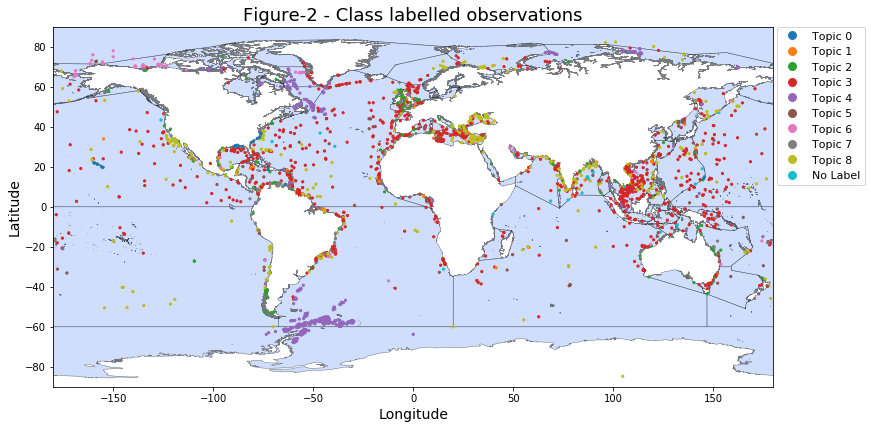

In [18]:
# Reduced observations
base = worldSeas.geometry.plot(figsize=(10,10),color='#a2bffe',edgecolor='black',linewidth=0.5,alpha = 0.5)
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
       'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

color = [col[i] for i in reducedGeoMessages.Label]
labelpoints = reducedGeoMessages.drop_duplicates(subset=['Label']).centroid
reducedGeoMessages.centroid.plot(figsize=(10,10),ax = base,markersize=5,c=color)

legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=('Topic '+ str(i)),markerfacecolor=col[i],
                          markersize=10) if i != 9 else Line2D([0], [0], marker='o', color='w',
                          label='No Label',markerfacecolor=col[i],
                          markersize=10) for i in sorted(pd.unique(reducedGeoMessages.Label))]


plt.legend(handles=legend_elements,bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,prop={"size":11})#, loc='center',['Topic1','Topic2','Topic3','Topic4']
plt.xlim(-180,180)
plt.ylim(-90,90)
plt.xlabel('Longitude',fontsize = 14)
plt.ylabel('Latitude',fontsize = 14)
plt.title('Figure-2 - Class labelled observations',fontsize = 18)
#plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(NullLocator())
#plt.gca().yaxis.set_major_locator(NullLocator())
#savefig("filename.pdf"

plt.savefig('PointsByLabel.png', bbox_inches = 'tight',
    pad_inches = 0)
#plt.show()

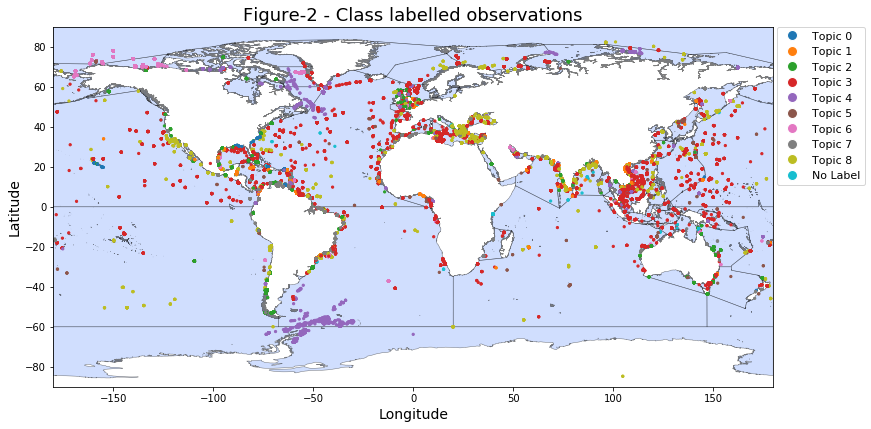

In [19]:
base = worldSeas.geometry.plot(figsize=(10,10),color='#a2bffe',edgecolor='black',linewidth=0.5,alpha = 0.5)
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
       'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

color = [col[i] for i in geoMessages.Label]
#labelpoints = reducedGeoMessages.drop_duplicates(subset=['Label']).centroid
geometryFrame.centroid.plot(figsize=(10,10),ax = base,markersize=5,c=color)

legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=('Topic '+ str(i)),markerfacecolor=col[i],
                          markersize=10) if i != 9 else Line2D([0], [0], marker='o', color='w',
                          label='No Label',markerfacecolor=col[i],
                          markersize=10) for i in sorted(pd.unique(geoMessages.Label))]


plt.legend(handles=legend_elements,bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,prop={"size":11})#, loc='center',['Topic1','Topic2','Topic3','Topic4']
plt.xlim(-180,180)
plt.ylim(-90,90)
plt.xlabel('Longitude',fontsize = 14)
plt.ylabel('Latitude',fontsize = 14)
plt.title('Figure-2 - Class labelled observations',fontsize = 18)
#plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(NullLocator())
#plt.gca().yaxis.set_major_locator(NullLocator())
#savefig("filename.pdf"

plt.savefig('PointsByLabel_All.png', bbox_inches = 'tight',
    pad_inches = 0)
#plt.show()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [24]:
# Joining the individual-cleaned words back to cleaned messages
clean_document = [' '.join(i) for i in messages_clean]

# Pre-processing the document
vectorizer = TfidfVectorizer(stop_words='english')
X_clean = vectorizer.fit_transform(clean_document)

# Setting the parameters for the model
true_k = 9
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,random_state=2019)
model.fit(X_clean)

# Extract the insights obtained from K-NN
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
knnGroups10 = [[terms[ind] for ind in order_centroids[i,0:10]] for i in np.arange(len(order_centroids))]
knnGroups4 = [[terms[ind] for ind in order_centroids[i,0:4]] for i in np.arange(len(order_centroids))]
# Printing the results for comparison with RLACL
print('The associated words, found by KNN, for each topic are:\n')
for i in np.arange(true_k):
    print('Topic %d:' % i, [terms[ind] for ind in order_centroids[i,0:4]])
    
# Let's quantify the performance
holderRLACL = []
holderKNN10 = []
holderKNN4 = []
for i in np.arange(topics):
    if i == 0:
        holderRLACL = groups[i][:]
        holderKNN10 = knnGroups10[i][:]
        holderKNN4 = knnGroups4[i][:]
    else:
        holderRLACL += groups[i]
        holderKNN10 += knnGroups10[i]
        holderKNN4 += knnGroups4[i]

accuracyCounts10 = [True if i in holderKNN10 else False for i in holderRLACL]
accuracyCounts4 = [True if i in holderKNN4 else False for i in holderRLACL]

print('\nThe word similarity (Top-10 for each Cluster) is %.3f' % (sum(accuracyCounts10)/len(holderRLACL)*100),'%')
print('\nThe word similarity (Top-4 for each Cluster) is %.3f' % (sum(accuracyCounts4)/len(holderRLACL)*100),'%')

The associated words, found by KNN, for each topic are:

Topic 0: ['buoy', 'station', 'air', 'navigation']
Topic 1: ['berth', 'operation', 'requested', 'survey']
Topic 2: ['light', 'unlit', 'punta', 'island']
Topic 3: ['reported', 'hydrolant', 'iceberg', 'shoal']
Topic 4: ['vessel', 'vicinity', 'possible', 'assist']
Topic 5: ['scientific', 'mooring', 'established', 'subsurface']
Topic 6: ['dangerous', 'wreck', 'rock', 'submerged']
Topic 7: ['mile', 'sec', 'light', 'degree']
Topic 8: ['area', 'hazardous', 'daily', 'bound']

The word similarity (Top-10 for each Cluster) is 83.333 %

The word similarity (Top-4 for each Cluster) is 66.667 %
